## 1. Import Libraries

In [1]:
import os
import re
import csv
import sys
import ast
import pickle
import argparse
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

from gensim.models import KeyedVectors
from collections import Counter, defaultdict, OrderedDict
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize
from transformers import AutoTokenizer

from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
diag_ccs_single_file_path = './data/mimic-iii/ccs_single_dx_tool_2015.csv'
diag_ccs_multi_file_path = './data/mimic-iii/ccs_multi_dx_tool_2015.csv'

pat_file_path = './data/mimic-iii/PATIENTS.csv'
adm_file_path = './data/mimic-iii/ADMISSIONS.csv'
diag_file_path = './data/mimic-iii/DIAGNOSES_ICD.csv'
note_file_path = './data/mimic-iii/NOTEEVENTS.csv'

out_dir = './processed/diagnosis/mimic_iii/'

## 2. Process Demographics

In [3]:
df_pat = pd.read_csv(pat_file_path, 
                     parse_dates = ['DOB'], 
                     infer_datetime_format = True, 
                     engine = "c")

In [4]:
df_adm = pd.read_csv(adm_file_path, 
                     parse_dates = ['ADMITTIME', 'DISCHTIME', 'DEATHTIME'], 
                     infer_datetime_format = True, 
                     engine = "c")

In [5]:
df_pat_ = df_pat[['SUBJECT_ID', 'GENDER', 'DOB']]

In [6]:
df_adm_ = df_adm[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 
                 'ADMISSION_TYPE',  'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 
                 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']]

In [7]:
df_pat_adm = pd.merge(df_pat_, df_adm_, on = ['SUBJECT_ID'], how = 'left')
df_pat_adm = df_pat_adm.sort_values(by='SUBJECT_ID').reset_index(drop=True)

In [8]:
df_pat_adm.head(5)

,SUBJECT_ID,GENDER,DOB,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY
0,2,M,2138-07-17,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN
1,3,M,2025-04-11,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE
2,4,F,2143-05-12,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE
3,5,M,2103-02-02,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN
4,6,F,2109-06-21,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE


In [9]:
# Calculate age and merge to previous dataframe
def calculate_and_add_age_to_df(df_pat_adm):

    rows = list()
    exception_ids = list()

    for index, row in tqdm(df_pat_adm.iterrows()):

        try:
            age_at_admission = row['ADMITTIME'] - row['DOB']        
            total_days = age_at_admission.days
            total_days = int(total_days)            
            total_years = total_days / 365.25

            row['AGE'] = int(total_years)
            rows.append(row)

        except Exception as e:
            exception_ids.append(row['SUBJECT_ID'])

    merged_df = pd.DataFrame(rows)
    
    return merged_df, exception_ids

In [10]:
df_pat_adm, exception_pids = calculate_and_add_age_to_df(df_pat_adm)

58976it [00:13, 4310.37it/s]


In [11]:
print(len(exception_pids))

2616


In [12]:
# Check pids in exception list are still in the dataframe
df_pat_adm[df_pat_adm['SUBJECT_ID'].isin(exception_pids)]

,SUBJECT_ID,GENDER,DOB,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,AGE


In [13]:
newborn_rows_pids = list(set(df_pat_adm[df_pat_adm.ADMISSION_TYPE == 'NEWBORN'].SUBJECT_ID.unique()))

In [14]:
len(newborn_rows_pids)

7830

In [15]:
df_pat_adm = df_pat_adm[~df_pat_adm['SUBJECT_ID'].isin(newborn_rows_pids)]

In [16]:
df_pat_adm['LENGTH_OF_STAY'] = (df_pat_adm['DISCHTIME'] - df_pat_adm['ADMITTIME']).apply(lambda x: x.total_seconds() / (24*60*60))

In [17]:
df_pat_adm = df_pat_adm[(df_pat_adm['LENGTH_OF_STAY'] >= 0)]

In [18]:
df_pat_adm['POST_DISCH_TIME'] = (df_pat_adm['DEATHTIME'] - df_pat_adm['DISCHTIME']).apply(lambda x: x.total_seconds() / (24*60*60))

In [19]:
condition = (df_pat_adm['POST_DISCH_TIME'] > 30) | (df_pat_adm['POST_DISCH_TIME'].isna())

In [20]:
df_pat_adm = df_pat_adm[condition]

In [21]:
df_pat_adm.head(5)

,SUBJECT_ID,GENDER,DOB,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,AGE,LENGTH_OF_STAY,POST_DISCH_TIME
1,3,M,2025-04-11,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,76,10.784722,NaN
2,4,F,2143-05-12,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,47,7.759028,NaN
4,6,F,2109-06-21,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,65,16.364583,NaN
9,11,F,2128-02-22,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,NaN,OTHER,MARRIED,WHITE,50,25.529167,NaN
11,13,F,2127-02-27,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,NaN,OTHER,NaN,WHITE,39,6.855556,NaN


In [22]:
df_pat_adm = df_pat_adm[df_pat_adm['AGE'] >= 18]
df_pat_adm = df_pat_adm.reset_index(drop=True)

In [23]:
df_pat_adm = df_pat_adm.drop(['RELIGION'], axis=1)
df_pat_adm = df_pat_adm.drop(['LANGUAGE'], axis=1)

df_pat_adm['MARITAL_STATUS'] = df_pat_adm['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

df_pat_adm['ETHNICITY'] = df_pat_adm['ETHNICITY'].map({
        'ASIAN': 'ASIAN',
        'ASIAN - ASIAN INDIAN': 'ASIAN',
        'ASIAN - CAMBODIAN': 'ASIAN',
        'ASIAN - CHINESE': 'ASIAN',
        'ASIAN - FILIPINO': 'ASIAN',
        'ASIAN - JAPANESE': 'ASIAN',
        'ASIAN - KOREAN': 'ASIAN',
        'ASIAN - OTHER': 'ASIAN',
        'ASIAN - THAI': 'ASIAN',
        'ASIAN - VIETNAMESE': 'ASIAN',

        'WHITE': 'WHITE',
        'WHITE - BRAZILIAN': 'WHITE',
        'WHITE - EASTERN EUROPEAN': 'WHITE',
        'WHITE - OTHER EUROPEAN': 'WHITE',
        'WHITE - RUSSIAN': 'WHITE',

        'BLACK/AFRICAN': 'AFRICAN AMERICAN/BLACK',
        'BLACK/AFRICAN AMERICAN': 'AFRICAN AMERICAN/BLACK',
        'BLACK/CAPE VERDEAN': 'AFRICAN AMERICAN/BLACK',
        'BLACK/HAITIAN': 'AFRICAN AMERICAN/BLACK',

        'HISPANIC OR LATINO': 'HISPANIC/LATINO',
        'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)': 'HISPANIC/LATINO',
        'HISPANIC/LATINO - COLOMBIAN': 'HISPANIC/LATINO',
        'HISPANIC/LATINO - CUBAN': 'HISPANIC/LATINO',
        'HISPANIC/LATINO - DOMINICAN': 'HISPANIC/LATINO',
        'HISPANIC/LATINO - GUATEMALAN': 'HISPANIC/LATINO',
        'HISPANIC/LATINO - HONDURAN': 'HISPANIC/LATINO',
        'HISPANIC/LATINO - MEXICAN': 'HISPANIC/LATINO',
        'HISPANIC/LATINO - PUERTO RICAN': 'HISPANIC/LATINO',
        'HISPANIC/LATINO - SALVADORAN': 'HISPANIC/LATINO',

        'MIDDLE EASTERN': 'other',
        'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'other',
        'PORTUGUESE': 'other',
        'SOUTH AMERICAN': 'other',

        'CARIBBEAN ISLAND': 'other',
        'AMERICAN INDIAN/ALASKA NATIVE': 'other',
        'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 'other',

        'PATIENT DECLINED TO ANSWER': 'other',
        'MULTI RACE ETHNICITY': 'other',
        'UNABLE TO OBTAIN': 'other',
        'OTHER': 'other',
        'UNKNOWN/NOT SPECIFIED': 'other',
    })

In [24]:
df_pat_adm = df_pat_adm.sort_values(by=['SUBJECT_ID', 'ADMITTIME']).reset_index(drop=True)

In [25]:
df_pat_adm['NEXT_ADMITTIME'] = df_pat_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)

In [26]:
df_pat_adm['TEMP_VISIT_INTERVAL'] = (df_pat_adm['NEXT_ADMITTIME'] - df_pat_adm['DISCHTIME']).dt.total_seconds() / (24*60*60)

In [27]:
df_pat_adm['VISIT_INTERVAL'] = df_pat_adm.groupby('SUBJECT_ID')['TEMP_VISIT_INTERVAL'].shift(1)

In [28]:
df_pat_adm.drop(columns=['TEMP_VISIT_INTERVAL'], inplace=True)

In [29]:
df_pat_adm.head(5)

,SUBJECT_ID,GENDER,DOB,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,MARITAL_STATUS,ETHNICITY,AGE,LENGTH_OF_STAY,POST_DISCH_TIME,NEXT_ADMITTIME,VISIT_INTERVAL
0,3,M,2025-04-11,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,MARRIED,WHITE,76,10.784722,NaN,NaT,NaN
1,4,F,2143-05-12,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,SINGLE,WHITE,47,7.759028,NaN,NaT,NaN
2,6,F,2109-06-21,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,MARRIED,WHITE,65,16.364583,NaN,NaT,NaN
3,11,F,2128-02-22,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,MARRIED,WHITE,50,25.529167,NaN,NaT,NaN
4,13,F,2127-02-27,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,UNKNOWN (DEFAULT),WHITE,39,6.855556,NaN,NaT,NaN


In [30]:
demographics_column_list = [
    'AGE',
    'GENDER',
    'ADMISSION_TYPE',
    'ADMISSION_LOCATION',
    'DISCHARGE_LOCATION',
    'INSURANCE',
    'MARITAL_STATUS',
    'ETHNICITY',
]

df_pat_adm_demo = df_pat_adm[demographics_column_list]

In [31]:
df_pat_adm_demo.head(5)

,AGE,GENDER,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,MARITAL_STATUS,ETHNICITY
0,76,M,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,MARRIED,WHITE
1,47,F,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,SINGLE,WHITE
2,65,F,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,MARRIED,WHITE
3,50,F,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,MARRIED,WHITE
4,39,F,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,UNKNOWN (DEFAULT),WHITE


In [32]:
for column in df_pat_adm_demo.columns.to_list():
    print(column)
    print(df_pat_adm_demo['{}'.format(column)].unique())
    print('\n')

AGE
[76 47 65 50 39 75 87 64 71 58 72 74 45 82 69 68 56 61 32 80 42 73 38 54
 88 26 70 41 36 57 48 52 43 85 44 28 40 60 35 62 20 22 23 24 25 66 49 77
 51 53 55 78 37 79 63 67 86 46 29 34 83 33 30 27 18 81 84 59 19 21 31]


GENDER
['M' 'F']


ADMISSION_TYPE
['EMERGENCY' 'ELECTIVE' 'URGENT']


ADMISSION_LOCATION
['EMERGENCY ROOM ADMIT' 'PHYS REFERRAL/NORMAL DELI'
 'TRANSFER FROM HOSP/EXTRAM' 'CLINIC REFERRAL/PREMATURE'
 'TRANSFER FROM OTHER HEALT' 'TRANSFER FROM SKILLED NUR'
 '** INFO NOT AVAILABLE **' 'HMO REFERRAL/SICK'
 'TRSF WITHIN THIS FACILITY']


DISCHARGE_LOCATION
['SNF' 'HOME WITH HOME IV PROVIDR' 'HOME HEALTH CARE' 'HOME'
 'REHAB/DISTINCT PART HOSP' 'DISC-TRAN CANCER/CHLDRN H'
 'LONG TERM CARE HOSPITAL' 'DISC-TRAN TO FEDERAL HC'
 'HOSPICE-MEDICAL FACILITY' 'SHORT TERM HOSPITAL'
 'LEFT AGAINST MEDICAL ADVI' 'HOSPICE-HOME' 'DISCH-TRAN TO PSYCH HOSP'
 'OTHER FACILITY' 'ICF' 'DEAD/EXPIRED' 'SNF-MEDICAID ONLY CERTIF']


INSURANCE
['Medicare' 'Private' 'Medicaid' 'Government' 'Self P

## 3. Clinical Notes Processing

In [33]:
df_notes = pd.read_csv(note_file_path, 
                       low_memory = False, 
                       engine = "c")

In [34]:
df_notes = df_notes[['SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'TEXT']]

In [35]:
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

In [36]:
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()

In [37]:
df_notes_dis_sum_last = df_notes_dis_sum_last.drop(['CATEGORY'], axis=1)

In [38]:
def preprocess_note(df): 

    def remove_unncessary_text(x):
        y=re.sub('\\[(.*?)\\]','',x) #remove de-identified brackets
        y=re.sub('[0-9]+\.','',y)    #remove 1.2. since the segmenter segments based on this
        y=re.sub('dr\.','doctor',y)
        y=re.sub('m\.d\.','md',y)
        y=re.sub('admission date:','',y)
        y=re.sub('discharge date:','',y)
        y=re.sub('--|__|==','',y)
        return y
    
    df['TEXT']=df['TEXT'].fillna(' ')
    df['TEXT']=df['TEXT'].str.replace('\n',' ')
    df['TEXT']=df['TEXT'].str.replace('\r',' ')
    df['TEXT']=df['TEXT'].apply(str.strip)
    df['TEXT']=df['TEXT'].str.lower()
    df['TEXT']=df['TEXT'].apply(lambda x: ' '.join(str(x).split()))
    df['TEXT']=df['TEXT'].apply(lambda x: remove_unncessary_text(x))
    
    return df

In [39]:
df_processed_notes = preprocess_note(df_notes_dis_sum_last)

In [40]:
df_processed_notes.head(5)

,SUBJECT_ID,HADM_ID,TEXT
0,3,145834.0,date of birth: sex: m service: medicine c...
1,4,185777.0,date of birth: sex: f service: chief comp...
2,6,107064.0,date of birth: sex: f service: admission d...
3,9,150750.0,"name: , unit no: date of birth: sex: m ..."
4,10,184167.0,date of birth: sex: f service: history of...


In [41]:
def remove_subject_ids_lacking_note_info(df_pat_adm, df_notes):
    df_pat_adm_notes = pd.merge(df_pat_adm, df_notes, on = ['SUBJECT_ID', 'HADM_ID'], how = 'left')
    
    missing_ratio = df_pat_adm_notes.TEXT.isnull().sum() / len(df_pat_adm_notes)
    print("there are {:.4f}% of rows missing note information.".format(missing_ratio))
    
    subject_ids_to_remove = df_pat_adm_notes[df_pat_adm_notes['TEXT'].isna()].SUBJECT_ID.tolist()    
    df_pat_adm_notes_clean = df_pat_adm_notes[~df_pat_adm_notes['SUBJECT_ID'].isin(subject_ids_to_remove)]
    
    print("there are {} subject ids.".format(len(df_pat_adm_notes_clean.SUBJECT_ID.unique().tolist())))
    
    df_pat_adm_notes_clean = df_pat_adm_notes_clean.reset_index(drop=True)
    
    return df_pat_adm_notes_clean

In [42]:
def get_statistics_of_processed_note(df):

    textlist = df.TEXT.tolist()
    token_len_list = list()

    for text in tqdm(textlist):
        token_len = len(text.split())
        token_len_list.append(token_len)
        
    plt.hist(token_len_list, bins=30)[2]

In [43]:
df_pat_adm_notes = remove_subject_ids_lacking_note_info(df_pat_adm, df_processed_notes)

there are 0.0310% of rows missing note information.
there are 31412 subject ids.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 40432/40432 [00:01<00:00, 21400.20it/s]


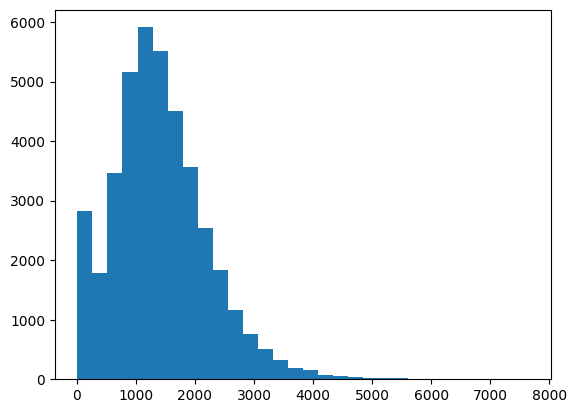

In [44]:
get_statistics_of_processed_note(df_pat_adm_notes)

## 4. ICD-9 Codes Processing

In [45]:
class LabelsForData(object):
    def __init__(self, ccs_single_file, ccs_multi_file):
        
        self.ccs_single_df = pd.read_csv(ccs_single_file, header=0, dtype=object)
        self.ccs_multi_df = pd.read_csv(ccs_multi_file, header=0, dtype=object)
        self.code2single = {}
        self.code2first_level = {}
        self.build_maps()

    def build_maps(self):
        
        for i, row in self.ccs_single_df.iterrows():
            code = row[0][1:-1].strip()
            single_cat = row[1][1:-1].strip()
            self.code2single[code] = single_cat
        
        for i, row in self.ccs_multi_df.iterrows():
            code = row[0][1:-1].strip()
            level_1_cat = row[1][1:-1].strip()
            self.code2first_level[code] = level_1_cat

In [46]:
def icd_diag_ccs_processing(
    adm_file_path, 
    diag_file_path, 
    diag_ccs_single_file_path, 
    diag_ccs_multi_file_path, 
    new_admIdList_threshold=2
):

    # ICD->CCS single category mapping
    label4data_diag = LabelsForData(diag_ccs_single_file_path, diag_ccs_multi_file_path)
    
    print('Building pid-admission mapping, admission-date mapping')
    
    pidAdmMap = {}          # patient id->admission id
    admDateMap = {}         # admission id->admission date
    disDateMap = {}         # discharge id->discharge date
    
    infd = open(adm_file_path, 'r')      # open admission table
    infd.readline()
    
    for line in infd:
        tokens = line.strip().split(',')
        pid = int(tokens[1])
        admId = int(tokens[2])
        admTime = datetime.strptime(tokens[3], '%Y-%m-%d %H:%M:%S')
        disTime = datetime.strptime(tokens[4], '%Y-%m-%d %H:%M:%S')
        admDateMap[admId] = admTime
        disDateMap[admId] = disTime
        
        if pid in pidAdmMap:
            pidAdmMap[pid].append(admId)
        else:
            pidAdmMap[pid] = [admId]
        
    infd.close()
        
    print('Building admission-diagList mapping')
    
    admDiagMap = {}                 # admission id->diag ICD
    admDiagMap_ccs_single = {}      # admission id->diag ICD (ccs single)
    admDiagMap_ccs_multi = {}      # admission id->diag ICD (ccs multi)
    
    infd = open(diag_file_path, 'r')
    infd.readline()
    
    for line in infd:
        tokens = line.strip().split(',')
        admId = int(tokens[2])
        diag = tokens[4][1:-1]
        if len(diag) == 0:
            continue

        diagStr = 'D_' + diag                                             # e.g. D_40301
        diagStr_ccs_single = 'D_' + label4data_diag.code2single[diag]     # e.g. D_99
        diagStr_ccs_multi = 'D_' + label4data_diag.code2first_level[diag]

        if admId in admDiagMap:
            admDiagMap[admId].append(diagStr)
        else:
            admDiagMap[admId] = [diagStr]

        if admId in admDiagMap_ccs_single:
            admDiagMap_ccs_single[admId].append(diagStr_ccs_single)
        else:
            admDiagMap_ccs_single[admId] = [diagStr_ccs_single]

        if admId in admDiagMap_ccs_multi:
            admDiagMap_ccs_multi[admId].append(diagStr_ccs_multi)
        else:
            admDiagMap_ccs_multi[admId] = [diagStr_ccs_multi]
            
    infd.close()

    print('Building pid-sortedVisits mapping')
    
    pidDiagMap = {}                 # pid->diag
    pidDiagMap_ccs_single = {}
    pidDiagMap_ccs_multi = {}
    
    pid_list = list()
    hadm_id_list = list()
    
    for pid, admIdList in pidAdmMap.items():        # pid->admission id
        new_admIdList = []
        
        for admId in admIdList:
            if admId in admDiagMap:
                new_admIdList.append(admId)
        
        if len(new_admIdList) < new_admIdList_threshold:
            continue
        
        pid_list.append(pid)
        hadm_id_list.append(new_admIdList)
        
        sortedDiagList = sorted([(admDateMap[admId], disDateMap[admId], admDiagMap[admId]) for admId in new_admIdList])
        pidDiagMap[pid] = sortedDiagList

        sortedDiagList_ccs_single = sorted([(admDateMap[admId], admDiagMap_ccs_single[admId]) for admId in new_admIdList])
        pidDiagMap_ccs_single[pid] = sortedDiagList_ccs_single

        sortedDiagList_ccs_multi = sorted([(admDateMap[admId], admDiagMap_ccs_multi[admId]) for admId in new_admIdList])
        pidDiagMap_ccs_multi[pid] = sortedDiagList_ccs_multi
    
    print('Building diagSeqs, diagSeqs_ccs_single, timeSeqs')
    
    diag_seqs = list()
    diag_seqs_ccs_single = list()
    diag_seqs_ccs_multi = list()
    
    time_seqs = list()

    for pid, visits in pidDiagMap.items():
        
        seq = list()
        time = list()
        los_ = list()
        first_time = visits[0][0]

        for j, visit in enumerate(visits):
            current_time = visit[0]
            discharge_time = visit[1]
            seq.append(visit[2])
            
            interval = (current_time - first_time).days
            time.append(interval)
            
        diag_seqs.append(seq)
        time_seqs.append(time)

    for pid, visits in pidDiagMap_ccs_single.items():       # diag ICD List (ccs single) of patient
        seq = []
        for i, visit in enumerate(visits):
            seq.append(visit[1])
        diag_seqs_ccs_single.append(seq)

    for pid, visits in pidDiagMap_ccs_multi.items():       # diag ICD List (ccs single) of patient
        seq = []
        for i, visit in enumerate(visits):
            seq.append(visit[1])
        diag_seqs_ccs_multi.append(seq)
        
    df_codes = {
        'SUBJECT_ID': [pid for pid, times in zip(pid_list, time_seqs) for _ in times],
        'HADM_ID': [hadm_id for hadm_ids in hadm_id_list for hadm_id in hadm_ids],
        
        'DIAG_SEQS': [diag for diags in diag_seqs for diag in diags],
        'DIAG_SEQS_CCS_SINGLE': [diag for diags in diag_seqs_ccs_single for diag in diags],
        'DIAG_SEQS_CCS_MULTI': [diag for diags in diag_seqs_ccs_multi for diag in diags]
    }
        
    df_codes = pd.DataFrame(df_codes)
    df_codes = df_codes.sort_values(by=['SUBJECT_ID']).reset_index(drop=True)
    
    hadm_id_list = [item for sublist in hadm_id_list for item in sublist]
    
    return df_codes, set(pid_list), set(hadm_id_list)

In [47]:
df_diag_codes, pid_diag_list, hadm_diag_list = icd_diag_ccs_processing(
    adm_file_path, 
    diag_file_path, 
    diag_ccs_single_file_path, 
    diag_ccs_multi_file_path
)

Building pid-admission mapping, admission-date mapping
Building admission-diagList mapping
Building pid-sortedVisits mapping
Building diagSeqs, diagSeqs_ccs_single, timeSeqs


## 5. Data Merging and Cleansing

In [48]:
df_pat_adm_notes_diag_codes = pd.merge(df_pat_adm_notes, df_diag_codes, on = ['SUBJECT_ID', 'HADM_ID'], how = 'left')

In [49]:
diag_seqs_null_rows = df_pat_adm_notes_diag_codes[df_pat_adm_notes_diag_codes['DIAG_SEQS'].isnull()]

In [50]:
diag_seqs_null_rows_pids = list(set(diag_seqs_null_rows.SUBJECT_ID.unique()))

In [51]:
len(diag_seqs_null_rows_pids)

25061

In [52]:
df_pat_adm_notes_diag_codes = df_pat_adm_notes_diag_codes[~df_pat_adm_notes_diag_codes['SUBJECT_ID'].isin(diag_seqs_null_rows_pids)]

In [53]:
df_pat_adm_notes_diag_codes = df_pat_adm_notes_diag_codes.sort_values(by=['SUBJECT_ID', 'ADMITTIME']).reset_index(drop=True)

In [54]:
def check_consistency(row):
    lengths = [len(x) for x in row[1:]]
    return all(length == lengths[0] for length in lengths)

In [55]:
df_pat_adm_notes_diag_codes_filtered = df_pat_adm_notes_diag_codes.groupby('SUBJECT_ID').agg(lambda x: list(x)).reset_index()
df_pat_adm_notes_diag_codes_filtered['Consistency'] = df_pat_adm_notes_diag_codes_filtered.apply(check_consistency, axis=1)
set(df_pat_adm_notes_diag_codes_filtered['Consistency'].to_list())

{True}

In [56]:
len(df_pat_adm_notes_diag_codes_filtered.SUBJECT_ID.unique())

6351

In [57]:
df_pat_adm_notes_diag_codes_filtered['length'] = df_pat_adm_notes_diag_codes_filtered['GENDER'].apply(lambda x: len(x))

In [58]:
len_one_df = df_pat_adm_notes_diag_codes_filtered[df_pat_adm_notes_diag_codes_filtered['length'] == 1]

In [59]:
len_one_df_pids = list(set(len_one_df.SUBJECT_ID.unique()))

In [60]:
df_pat_adm_notes_diag_codes_filtered = df_pat_adm_notes_diag_codes_filtered[~df_pat_adm_notes_diag_codes_filtered['SUBJECT_ID'].isin(len_one_df_pids)]

In [61]:
df_pat_adm_notes_diag_codes_filtered = df_pat_adm_notes_diag_codes_filtered.reset_index(drop=True)

In [62]:
df_pat_adm_notes_diag_codes_filtered.head(5)

,SUBJECT_ID,GENDER,DOB,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,...,LENGTH_OF_STAY,POST_DISCH_TIME,NEXT_ADMITTIME,VISIT_INTERVAL,TEXT,DIAG_SEQS,DIAG_SEQS_CCS_SINGLE,DIAG_SEQS_CCS_MULTI,Consistency,length
0,17,"[F, F]","[2087-07-14 00:00:00, 2087-07-14 00:00:00]","[194023, 161087]","[2134-12-27 07:15:00, 2135-05-09 14:11:00]","[2134-12-31 16:05:00, 2135-05-13 14:40:00]","[NaT, NaT]","[ELECTIVE, EMERGENCY]","[PHYS REFERRAL/NORMAL DELI, EMERGENCY ROOM ADMIT]","[HOME HEALTH CARE, HOME HEALTH CARE]",...,"[4.368055555555555, 4.020138888888889]","[nan, nan]","[2135-05-09 14:11:00, NaT]","[nan, 128.92083333333332]",[ date of birth: sex: f service: cardiotho...,"[[D_7455, D_45829, D_V1259, D_2724], [D_4239, ...","[[D_213, D_238, D_117, D_53], [D_97, D_130, D_...","[[D_14, D_16, D_7, D_3], [D_7, D_8, D_17, D_7,...",True,2
1,23,"[M, M]","[2082-07-17 00:00:00, 2082-07-17 00:00:00]","[152223, 124321]","[2153-09-03 07:15:00, 2157-10-18 19:34:00]","[2153-09-08 19:10:00, 2157-10-25 14:00:00]","[NaT, NaT]","[ELECTIVE, EMERGENCY]","[PHYS REFERRAL/NORMAL DELI, TRANSFER FROM HOSP...","[HOME HEALTH CARE, HOME HEALTH CARE]",...,"[5.496527777777778, 6.768055555555556]","[nan, nan]","[2157-10-18 19:34:00, NaT]","[nan, 1501.0166666666667]",[ date of birth: sex: m service: cardiotho...,"[[D_41401, D_4111, D_4241, D_V4582, D_2724, D_...","[[D_101, D_101, D_96, D_101, D_53, D_98, D_164...","[[D_7, D_7, D_7, D_7, D_3, D_7, D_10, D_6], [D...",True,2
2,36,"[M, M, M]","[2061-08-17 00:00:00, 2061-08-17 00:00:00, 206...","[182104, 122659, 165660]","[2131-04-30 07:15:00, 2131-05-12 19:49:00, 213...","[2131-05-08 14:00:00, 2131-05-25 13:30:00, 213...","[NaT, NaT, NaT]","[EMERGENCY, EMERGENCY, ELECTIVE]","[CLINIC REFERRAL/PREMATURE, EMERGENCY ROOM ADM...","[HOME HEALTH CARE, REHAB/DISTINCT PART HOSP, L...",...,"[8.28125, 12.736805555555556, 10.073611111111111]","[nan, nan, nan]","[2131-05-12 19:49:00, 2134-05-10 11:30:00, NaT]","[nan, 4.242361111111111, 1080.9166666666667]",[ date of birth: sex: m service: cardiotho...,"[[D_41401, D_4111, D_496, D_4019, D_3051, D_53...","[[D_101, D_101, D_127, D_98, D_663, D_138, D_1...","[[D_7, D_7, D_8, D_7, D_5, D_9, D_10, D_2, D_1...",True,3
3,68,"[F, F]","[2132-02-29 00:00:00, 2132-02-29 00:00:00]","[170467, 108329]","[2173-12-15 16:16:00, 2174-01-04 22:21:00]","[2174-01-03 18:30:00, 2174-01-19 11:30:00]","[NaT, NaT]","[EMERGENCY, EMERGENCY]","[EMERGENCY ROOM ADMIT, EMERGENCY ROOM ADMIT]","[HOME HEALTH CARE, SNF]",...,"[19.093055555555555, 14.547916666666667]","[nan, nan]","[2174-01-04 22:21:00, NaT]","[nan, 1.1604166666666667]",[ date of birth: sex: f service: medicine ...,"[[D_042, D_486, D_4254, D_42820, D_4280, D_584...","[[D_5, D_122, D_97, D_108, D_108, D_157, D_158...","[[D_1, D_8, D_7, D_7, D_7, D_10, D_10, D_3, D_...",True,2
4,85,"[M, M]","[2090-09-18 00:00:00, 2090-09-18 00:00:00]","[116630, 112077]","[2162-03-02 14:04:00, 2167-07-25 18:49:00]","[2162-03-10 13:15:00, 2167-07-30 15:24:00]","[NaT, NaT]","[EMERGENCY, EMERGENCY]","[CLINIC REFERRAL/PREMATURE, CLINIC REFERRAL/PR...","[REHAB/DISTINCT PART HOSP, SNF]",...,"[7.965972222222222, 4.857638888888889]","[nan, nan]","[2167-07-25 18:49:00, NaT]","[nan, 1963.2319444444445]",[ date of birth: sex: m service: cardiotho...,"[[D_4241, D_20280, D_V4282, D_99811, D_3320, D...","[[D_96, D_38, D_259, D_238, D_79, D_651, D_138...","[[D_7, D_2, D_18, D_16, D_6, D_5, D_9, D_10, D...",True,2


In [63]:
df_pat_adm_notes_diag_codes_filtered = df_pat_adm_notes_diag_codes_filtered.drop(['Consistency'], axis=1)
df_expanded = pd.DataFrame(columns=df_pat_adm_notes_diag_codes_filtered.columns)

for index, row in tqdm(df_pat_adm_notes_diag_codes_filtered.iterrows()):
    max_len = row['length']
    for i in range(max_len):
        new_row = row.copy()
        for col in df_pat_adm_notes_diag_codes_filtered.columns.to_list()[1:-1]:
            try:
                new_row[col] = row[col][i]
            except IndexError:
                new_row[col] = None
        df_expanded = df_expanded.append(new_row, ignore_index=True)

0it [00:00, ?it/s]C:\Users\heejoonkoo\AppData\Local\Temp\ipykernel_19736\2885907659.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_expanded = df_expanded.append(new_row, ignore_index=True)
5551it [00:43, 128.98it/s]


In [64]:
df_pat_adm_notes_diag_codes_filtered = df_expanded

## 6. Save Data

In [65]:
demographics_column_list = [
    'AGE',
    'GENDER',
    'ADMISSION_TYPE',
    'ADMISSION_LOCATION',
    'DISCHARGE_LOCATION',
    'INSURANCE',
    'MARITAL_STATUS',
    'ETHNICITY',
]

def convert_column(df, column_list):

    for column in column_list:
        df[column] = LabelEncoder().fit_transform(df[column]) + 1
        df[column] = df[column].astype('category')
        
    return df

In [66]:
for column in df_pat_adm_notes_diag_codes_filtered[demographics_column_list].columns.to_list():
    print(column, len(df_pat_adm_notes_diag_codes_filtered['{}'.format(column)].unique()))

AGE 71
GENDER 2
ADMISSION_TYPE 3
ADMISSION_LOCATION 7
DISCHARGE_LOCATION 15
INSURANCE 5
MARITAL_STATUS 7
ETHNICITY 5


In [67]:
def convert_next_visit_diagnosis_df_to_pickle(
    data, 
    out_dir, 
    demographics_column_list,
    truncated_len,
    tokenizer
):

    # Make directory #
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    save_path = os.path.join(out_dir, 'diagnosis.csv')
    data.to_csv(save_path, index=False)
        
    data = convert_column(data, demographics_column_list)    
    grouped_data = data.groupby('SUBJECT_ID').agg(lambda x: list(x)).reset_index()
    
    # Meta Information #
    input_subject_ids_all = grouped_data.SUBJECT_ID.to_list()
    hadm_ids = grouped_data.HADM_ID.to_list()
    
    # Demographic Information #
    demographic_info = grouped_data[demographics_column_list]
    
    demo_seqs = list()
    for _, row in demographic_info.iterrows():
        max_len = max(len(item) for item in row)
        sub_rows = list()
        for idx in range(max_len):
            sub_row = [row[col][idx] if idx < len(row[col]) else None for col in demographic_info.columns]
            sub_rows.append(sub_row)
        demo_seqs.append(sub_rows)                
    
    # Time Information #
    visit_seqs = grouped_data.VISIT_INTERVAL.to_list()
    los_seqs = grouped_data.LENGTH_OF_STAY.to_list()

    # Medical Code Information #
    diag_seqs = grouped_data.DIAG_SEQS.to_list()
    diag_seqs_ccs_single = grouped_data.DIAG_SEQS_CCS_SINGLE.to_list()
    diag_seqs_ccs_multi = grouped_data.DIAG_SEQS_CCS_MULTI.to_list()

    dict_diag_ccs_single = dict()
    new_diag_seqs_ccs_single = list()
    for patient in diag_seqs_ccs_single:
        newPatient = list()
        for visit in patient:
            newVisit = list()
            for code in visit:
                if code in dict_diag_ccs_single:
                    newVisit.append(dict_diag_ccs_single[code])
                else:
                    dict_diag_ccs_single[code] = len(dict_diag_ccs_single)
                    newVisit.append(dict_diag_ccs_single[code])
            newPatient.append(newVisit)
        new_diag_seqs_ccs_single.append(newPatient)

    dict_diag_ccs_multi = dict()
    new_diag_seqs_ccs_multi = list()
    for patient in diag_seqs_ccs_multi:
        newPatient = list()
        for visit in patient:
            newVisit = list()
            for code in visit:
                if code in dict_diag_ccs_multi:
                    newVisit.append(dict_diag_ccs_multi[code])
                else:
                    dict_diag_ccs_multi[code] = len(dict_diag_ccs_multi)
                    newVisit.append(dict_diag_ccs_multi[code])
            newPatient.append(newVisit)
        new_diag_seqs_ccs_multi.append(newPatient)
    
    # Clinical Note Information #
    clinical_notes = grouped_data.TEXT.to_list()
    
    # Converting all information to list #
    input_hamd_ids_all = list()    
    input_demo_all = list()
    inputs_visit_seq_all = list()
    inputs_los_seq_all = list()
    
    inputs_diag_all = list()
    labels_diag = list()
    labels_diag_ccs_single_current_visit = list()
    labels_diag_ccs_single_next_visit = list()    
    labels_diag_ccs_multi_current_visit = list()    
    labels_diag_ccs_multi_next_visit = list()
    
    inputs_clinical_notes = list()
    
    vocab_set_diag = dict()
    max_visit_len = 0
    
    for i in tqdm(range(len(diag_seqs))):
        length = len(diag_seqs[i])

        if length >= truncated_len:            
            all_hamd_ids_seqs = hadm_ids[i][length - truncated_len:]            
            all_demo_seqs = demo_seqs[i][length - truncated_len:]  
            
            all_visit_seqs = visit_seqs[i][length - truncated_len:]
            all_los_seqs = los_seqs[i][length - truncated_len:]  
            
            all_diag_seqs = diag_seqs[i][length - truncated_len:]
            all_diag_seqs_ccs_single = new_diag_seqs_ccs_single[i][length - truncated_len:]
            all_diag_seqs_ccs_multi = new_diag_seqs_ccs_multi[i][length - truncated_len:]      
            
            all_clinical_notes = clinical_notes[i][length - truncated_len:]
        
        else:
            all_hamd_ids_seqs = hadm_ids[i]            
            all_demo_seqs = demo_seqs[i]    
            
            all_visit_seqs = visit_seqs[i]
            all_los_seqs = los_seqs[i]  
            
            all_diag_seqs = diag_seqs[i]
            all_diag_seqs_ccs_single = new_diag_seqs_ccs_single[i]
            all_diag_seqs_ccs_multi = new_diag_seqs_ccs_multi[i]        
            
            all_clinical_notes = clinical_notes[i]
                    
        clinical_note_ids_list = list()            
        for clinical_note in all_clinical_notes:    
            clinical_note_ids = tokenizer(clinical_note)['input_ids'][1:-1]
            clinical_note_ids_list.append(clinical_note_ids)
        
        input_hamd_ids = all_hamd_ids_seqs[:-1]
        input_hamd_ids_all.append(input_hamd_ids)           
        
        input_demo = all_demo_seqs[:-1]
        input_demo_all.append(input_demo)
        
        input_visit_seq = all_visit_seqs[:-1]
        input_los_seq = all_los_seqs[:-1]
        inputs_visit_seq_all.append(input_visit_seq)
        inputs_los_seq_all.append(input_los_seq)
        
        input_diag = all_diag_seqs[:-1]      
        label_diag_ccs_single = all_diag_seqs_ccs_single[-1]
        label_diag_ccs_single_current_visit = all_diag_seqs_ccs_single[:-1]
        label_diag_ccs_single_next_visit = all_diag_seqs_ccs_single[1:]
        label_diag_ccs_multi_current_visit = all_diag_seqs_ccs_multi[:-1]
        label_diag_ccs_multi_next_visit = all_diag_seqs_ccs_multi[1:]
        
        inputs_diag_all.append(input_diag)        
        labels_diag.append(label_diag_ccs_single)        
        labels_diag_ccs_single_current_visit.append(label_diag_ccs_single)
        labels_diag_ccs_single_next_visit.append(label_diag_ccs_single_next_visit)
        labels_diag_ccs_multi_current_visit.append(label_diag_ccs_multi_current_visit)
        labels_diag_ccs_multi_next_visit.append(label_diag_ccs_multi_next_visit)
        
        input_clinical_notes = clinical_note_ids_list[:-1]        
        inputs_clinical_notes.append(input_clinical_notes)        

        if len(input_diag) > max_visit_len:
            max_visit_len = len(input_diag)     # the max number of visits

        for visit in input_diag:
            if len(visit) > max_visit_len:
                max_visit_len = len(visit)
            for code in visit:
                if code in vocab_set_diag:
                    vocab_set_diag[code] += 1
                else:
                    vocab_set_diag[code] = 1
        
    # Converting all information to list #
    print('Saving model inputs')
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)  
    
    pickle.dump(input_subject_ids_all, open(os.path.join(out_dir, 'input_subject_ids.seqs'), 'wb'), -1)
    pickle.dump(input_demo_all, open(os.path.join(out_dir, 'input_demo.seqs'), 'wb'), -1)    
    pickle.dump(inputs_visit_seq_all, open(os.path.join(out_dir, 'input_visit_intervals.seqs'), 'wb'), -1)  
    pickle.dump(inputs_los_seq_all, open(os.path.join(out_dir, 'input_length_of_stays.seqs'), 'wb'), -1)  
    
    pickle.dump(inputs_diag_all, open(os.path.join(out_dir, 'input_diag.seqs'), 'wb'), -1)    
    pickle.dump(labels_diag, open(os.path.join(out_dir, 'labels_ccs_diag.label'), 'wb'), -1)
    
    pickle.dump(labels_diag_ccs_single_current_visit, open(os.path.join(out_dir, 'labels_current_visit_diag.label'), 'wb'), -1)
    pickle.dump(labels_diag_ccs_single_next_visit, open(os.path.join(out_dir, 'labels_next_visit_diag.label'), 'wb'), -1)
    pickle.dump(labels_diag_ccs_multi_current_visit, open(os.path.join(out_dir, 'labels_current_visit_diag_multi.label'), 'wb'), -1)
    pickle.dump(labels_diag_ccs_multi_next_visit, open(os.path.join(out_dir, 'labels_next_visit_diag_multi.label'), 'wb'), -1)

    pickle.dump(diag_seqs, open(os.path.join(out_dir, 'origin_diag.seqs'), 'wb'), -1)
    pickle.dump(new_diag_seqs_ccs_single, open(os.path.join(out_dir, 'origin_diag_ccs_single.seqs'), 'wb'), -1)
    pickle.dump(new_diag_seqs_ccs_multi, open(os.path.join(out_dir, 'origin_diag_ccs_multi.seqs'), 'wb'), -1)

    pickle.dump(dict_diag_ccs_single, open(os.path.join(out_dir, 'ccs_single_level_diag.dict'), 'wb'), -1) # 
    pickle.dump(dict_diag_ccs_multi, open(os.path.join(out_dir, 'ccs_multi_level_diag.dict'), 'wb'), -1)  #
    
    pickle.dump(inputs_clinical_notes, open(os.path.join(out_dir, 'input_clinical_notes.seqs'), 'wb'), -1)
    
    sorted_vocab_diag = {k: v for k, v in sorted(vocab_set_diag.items(), key=lambda item: item[1], reverse=True)}
    
    outfd = open(os.path.join(out_dir, 'vocab_diag.txt'), 'w')
    
    for k, v in sorted_vocab_diag.items():
        outfd.write(k + '\n')
        
    outfd.close()
    
    print('Saved model inputs')

In [68]:
truncated_len = 21
tokenizer = AutoTokenizer.from_pretrained("nlpie/tiny-clinicalbert")

convert_next_visit_diagnosis_df_to_pickle(
    df_pat_adm_notes_diag_codes_filtered, 
    out_dir, 
    demographics_column_list,
    truncated_len,
    tokenizer
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5551/5551 [00:43<00:00, 128.26it/s]


Saving model inputs
Saved model inputs


In [69]:
def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = OrderedDict()
    vocab['PAD'] = len(vocab)
    with open(vocab_file, "r", encoding="utf-8") as reader:
        while True:
            token = reader.readline()
            if not token:
                break
            token = token.strip()
            vocab[token] = len(vocab)
    return vocab


def tree_building(seqs_file, types_file, graph_file, out_file):

    print('Read Saved data dictionary')
    types = load_vocab(types_file)
    seqs = pickle.load(open(seqs_file, 'rb'))

    start_set = set(types.keys())
    hit_list = []

    cat1count = 0
    cat2count = 0
    cat3count = 0
    cat4count = 0

    graph = open(graph_file, 'r')
    _ = graph.readline()

    # add ancestors to dictionary
    for line in graph:
        tokens = line.strip().split(',')
        icd9 = tokens[0][1:-1].strip()
        cat1 = tokens[1][1:-1].strip()
        desc1 = 'A_L1_' + cat1
        cat2 = tokens[3][1:-1].strip()
        desc2 = 'A_L2_' + cat2
        cat3 = tokens[5][1:-1].strip()
        desc3 = 'A_L3_' + cat3
        cat4 = tokens[7][1:-1].strip()
        desc4 = 'A_L4_' + cat4

        icd9 = 'D_' + icd9

        if icd9 not in types:
            continue
        else:
            hit_list.append(icd9)

        if desc1 not in types:
            cat1count += 1
            types[desc1] = len(types)

        if len(cat2) > 0:
            if desc2 not in types:
                cat2count += 1
                types[desc2] = len(types)
        if len(cat3) > 0:
            if desc3 not in types:
                cat3count += 1
                types[desc3] = len(types)
        if len(cat4) > 0:
            if desc4 not in types:
                cat4count += 1
                types[desc4] = len(types)
    graph.close()

    # add root_code
    types['A_ROOT'] = len(types)
    root_code = types['A_ROOT']

    miss_set = start_set - set(hit_list)
    miss_set.remove('PAD')  # comment this line for GRAM and KAME, work for KEMCE
    print('missing code: {}'.format(len(miss_set)))
    print(cat1count, cat2count, cat3count, cat4count)

    five_map = {}
    four_map = {}
    three_map = {}
    two_map = {}
    one_map = dict([(types[icd], [types[icd], root_code]) for icd in miss_set])

    graph = open(graph_file, 'r')
    graph.readline()

    for line in graph:
        tokens = line.strip().split(',')
        icd9 = tokens[0][1:-1].strip()
        cat1 = tokens[1][1:-1].strip()
        desc1 = 'A_L1_' + cat1
        cat2 = tokens[3][1:-1].strip()
        desc2 = 'A_L2_' + cat2
        cat3 = tokens[5][1:-1].strip()
        desc3 = 'A_L3_' + cat3
        cat4 = tokens[7][1:-1].strip()
        desc4 = 'A_L4_' + cat4

        icd9 = 'D_' + icd9

        if icd9 not in types:
            continue

        icd_code = types[icd9]

        if len(cat4) > 0:
            code4 = types[desc4]
            code3 = types[desc3]
            code2 = types[desc2]
            code1 = types[desc1]
            five_map[icd_code] = [icd_code, root_code, code1, code2, code3, code4]
        elif len(cat3) > 0:
            code3 = types[desc3]
            code2 = types[desc2]
            code1 = types[desc1]
            four_map[icd_code] = [icd_code, root_code, code1, code2, code3]

        elif len(cat2) > 0:
            code2 = types[desc2]
            code1 = types[desc1]
            three_map[icd_code] = [icd_code, root_code, code1, code2]

        else:
            code1 = types[desc1]
            two_map[icd_code] = [icd_code, root_code, code1]

    # Now we re-map the integers to all medical leaf codes.
    new_five_map = OrderedDict()
    new_four_map = OrderedDict()
    new_three_map = OrderedDict()
    new_two_map = OrderedDict()
    new_one_map = OrderedDict()
    new_types = OrderedDict()
    types_reverse = dict([(v, k) for k, v in types.items()])

    srcs = []
    dsts = []
    vals = []

    code_count = 0
    new_types['PAD'] = code_count
    code_count += 1
    for icdCode, ancestors in five_map.items():
        new_types[types_reverse[icdCode]] = code_count
        new_five_map[code_count] = [code_count] + ancestors[1:]
        code_count += 1
        lst = [code_count] + ancestors[1:]
        for i in range(len(lst)-1):
           src = lst[i]-1
           dst = lst[i+1]-1
           srcs.append(src)
           dsts.append(dst)
           vals.append(1.0)
           srcs.append(dst)
           dsts.append(src)
           vals.append(1.0)

    for icdCode, ancestors in four_map.items():
        new_types[types_reverse[icdCode]] = code_count
        new_four_map[code_count] = [code_count] + ancestors[1:]
        code_count += 1
        lst = [code_count] + ancestors[1:]
        for i in range(len(lst) - 1):
            src = lst[i] - 1
            dst = lst[i + 1] - 1
            srcs.append(src)
            dsts.append(dst)
            vals.append(1.0)
            srcs.append(dst)
            dsts.append(src)
            vals.append(1.0)

    for icdCode, ancestors in three_map.items():
        new_types[types_reverse[icdCode]] = code_count
        new_three_map[code_count] = [code_count] + ancestors[1:]
        code_count += 1
        lst = [code_count] + ancestors[1:]
        for i in range(len(lst) - 1):
            src = lst[i] - 1
            dst = lst[i + 1] - 1
            srcs.append(src)
            dsts.append(dst)
            vals.append(1.0)
            srcs.append(dst)
            dsts.append(src)
            vals.append(1.0)

    for icdCode, ancestors in two_map.items():
        new_types[types_reverse[icdCode]] = code_count
        new_two_map[code_count] = [code_count] + ancestors[1:]
        code_count += 1
        lst = [code_count] + ancestors[1:]
        for i in range(len(lst) - 1):
            src = lst[i] - 1
            dst = lst[i + 1] - 1
            srcs.append(src)
            dsts.append(dst)
            vals.append(1.0)
            srcs.append(dst)
            dsts.append(src)
            vals.append(1.0)

    for icdCode, ancestors in one_map.items():
        new_types[types_reverse[icdCode]] = code_count
        new_one_map[code_count] = [code_count] + ancestors[1:]
        code_count += 1
        lst = [code_count] + ancestors[1:]
        for i in range(len(lst) - 1):
            src = lst[i] - 1
            dst = lst[i + 1] - 1
            srcs.append(src)
            dsts.append(dst)
            vals.append(1.0)
            srcs.append(dst)
            dsts.append(src)
            vals.append(1.0)

    inds = torch.LongTensor([srcs, dsts])
    vals = torch.FloatTensor(vals)
    spm = torch.sparse.FloatTensor(inds, vals, torch.Size([len(types_reverse)-1, len(types_reverse)-1]))

    new_seqs = []
    for patient in seqs:
        new_patient = []
        for visit in patient:
            new_visit = []
            for code in visit:
                new_visit.append(new_types[code])
            new_patient.append(new_visit)
        new_seqs.append(new_patient)

    pickle.dump(new_five_map, open(os.path.join(out_file, 'level5.pk'), 'wb'), -1)
    pickle.dump(new_four_map, open(os.path.join(out_file, 'level4.pk'), 'wb'), -1)
    pickle.dump(new_three_map, open(os.path.join(out_file, 'level3.pk'), 'wb'), -1)
    pickle.dump(new_two_map, open(os.path.join(out_file, 'level2.pk'), 'wb'), -1)
    pickle.dump(new_one_map, open(os.path.join(out_file, 'level1.pk'), 'wb'), -1)
    pickle.dump(new_types, open(os.path.join(out_file, 'inputs.dict'), 'wb'), -1)
    pickle.dump(new_seqs, open(os.path.join(out_file, 'inputs.seqs'), 'wb'), -1)
    pickle.dump(spm, open(os.path.join(out_file, 'graph.edges'), 'wb'), -1)
    print(len(new_types), len(new_seqs), len(types_reverse))

In [70]:
seqs_path = os.path.join(out_dir, 'input_diag.seqs')
vocab_path = os.path.join(out_dir, 'vocab_diag.txt')
multi_level_path = diag_ccs_multi_file_path
output = out_dir

tree_building(
    seqs_path, 
    vocab_path, 
    multi_level_path, 
    out_dir
)

Read Saved data dictionary
missing code: 0
17 126 300 178
3882 5551 4504
